In [1]:
# import necessary libraries
import re, string, unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

# import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score

from langdetect import detect


SEED=42

/var/folders/hv/xq_dj8v97_j03qt43slpb1q80000gn/T/ipykernel_19933/2010651174.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

In [3]:
# cargar los datos
df_original = pd.read_csv('data/tipo1_entrenamiento_estudiantes.csv')

# Entendimiento

In [4]:
df_original.shape

(7875, 2)

In [5]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7875 entries, 0 to 7874
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  7875 non-null   object
 1   Class   7875 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 123.2+ KB


In [6]:

df_original.sample(5)

,Review,Class
6632,"Excelente servicio, calidad y confort. con gusto volvería a hospedarme nuevamente con ustedes. las habitaciones están limpias cómodas. totalmente recomendable a un precio buen precio, espero regresar pronto.",5
2289,"Después de unos días disfrutando de las instalaciones del hotel, sobretodo de sus piscinas en las azoteas, con unas vistas de La Habana increíbles, mi familia y yo pudimos disfrutar de una cena de Gala de fin de año sorprendente, a base de buffet del hotel, pero con unas calidades de comida difíciles de encontrar en La Habana... Pero la parte que nos de´jo boquiabiertos fue el concierto de la Orquesta de cámara de la Orquesta Sinfónica Nacional de Cuba... en el mismo Loby del hotel y con una acústica que nos sorprendió disfrutamos de un concierto de año nuevo de casi hora y media, con la creme de la creme de la interpretación de música clásica del Caribe... Olé por los organizadores, hicieron que nuestra estancia en Cuba fuera más impresionante si cabe, con un trato del…",5
3635,Me he alojado recientemente en este hotel ... primero interacción con el hotel el frente el personal: se han perdido nuestra reserva. Esperamos un rato hasta que nos pareció ... entonces nos llevó hasta nuestra habitación ... bonito botones. PERO cuando en la habitación nos dimos cuenta de que el aire acondicionado era rompió ... el supervisor de limpieza era llamado dijo a/c estaba trabajando para darle tiempo para refrescarse. Teníamos nuestras dudas ... después que dejó que vierten a la ama de llaves y dijo que sí que la habitación a/c se rompió y mantienen colocar a las personas en esa habitación. Así que nos fuimos al bajar las escaleras para conseguir cambiar nuestra habitación ... nos dieron una nueva habitación ... pero no estaba lista ... finalmente nos dio una tercera…,2
5805,"Me estoy hospedando el día 23 al día 28 de diciembre, cada año me hospedo en este hotel en temporada navideña y en diversas ocaciones durante el año, he recibido un trato como el de un clente q por primera vez se hospeda, pedí una habitación un poco mas amplia y la sta. Daneli gloria, no autorizo, aun y cuando había habitaciones disponibles, me quería cobrar un ajuste en la tarifa. Uno espera como cliente frecuente un trato especial, sobre todo cuando tampoco representa para el hotel un esfuerzo importante, en fin, creo que con este tipo de actitud habiendo una opción similar de otra cadena lo tomaré. Estuve dos días antes en el renaissance de mcallen de esta cadena marriot con buen trato.",2
1187,"Bueno pero costoso para lo viejo que es su edificio. Sobre todo le falta mucho a las habitaciones, el baño se ve viejo en un barrio moderno. Le falta inversión también en la piscina y el lobby que se ven viejos en un sitio donde debería ser moderno. El servicio es bueno. Algo de resaltar es que es uno de los pocos hoteles que no se han equivocado en algo al momento de facturar.",3


In [7]:
df_stats = df_original.copy()
df_stats['Word_Count'] = df_stats['Review'].apply(lambda x: len(x.split()))
df_stats

,Review,Class,Word_Count
0,"Nos alojamos en una casa alquilada en la ciudad amurallada. Parecía tan segura como cualquier otra gran ciudad con un montón de buenos restaurantes, tiendas y vida nocturna. Gran lugar para un grupo con intereses variados, no estoy seguro de que le traiga a los niños aquí sólo porque no hay mucho que hacer para ellos. Asegúrate de aventurarse fuera de la ciudad, pero algunos también es un gran lugar para alojarse",4,72
1,"La comida está bien, pero nada especial. Yo tenía mejor comida Mexcan en los Estados Unidos. Las margaritas eran geniales. El Mahi Mahi pescado recocido y seco. La carne fajitas aceptable y el coco camarones sabroso. El tortilla chips aperitivo fue decepcionante.",3,42
2,"En mi opinión, no es una como muchos usuarios reclaman. Es un gran paladar que parece ser una parada con muchos grupos de excursión. El menú es más interesante que los otros restaurantes comimos en. La parte más interesante de la experiencia es que el...edificio está en una sección de La Habana Centro. Las plantas inferiores están muy deteriorados, y tienen apartamentos donde viven muchos trabajadores de restaurante. Los pisos superiores, donde el restaurante es, han sido restauradas a gloria pasada. Las reservas son imprescindibles. Plan de 40 a 50 CUC por persona para una comida con cócteles y vinos.Más",3,100
3,"esta curiosa forma que asemeja una silla de montar de ahi su nombre es el icono de la ciudad, vale mucho la pena si no puedes ubir lo puedes asdnirr de cualquier punto de la ciudad",4,36
4,Lo mejor era la limonada. Me gusto la comida de todo el mundo y era sosa y un poco frío.,2,20
...,...,...,...
7870,"El motivo de mi estancia fue porque vine a un congreso medico, y me hospedaron en este lugar, las instalaciones están bien sin ser excelentes, la habitación bien pero tardaban casi todo el día en llegar a hacer el aseo y arreglar el cuarto, la verdad siempre quedaba un poco sucio, la regadera tenía tapado el desagüe por lo que se hacía una alberca, los alimentos buenos (rescatable el pan que acompañan con café) Lo que si es muy bueno es la gente que trabaja en el hotel, son súper amables y serviciales. Este hotel es una buena opción para su estancia además que está a 3 cuadras de paseo Montejo. Saludos desde acá 😀",3,115
7871,"Es difícil revisar el castillo porque apenas podíamos caminar por el sofocante calor, pero no creo que puedas apreciar completamente este lugar a menos que tenía un guía o eran un historiador. De lo contrario, es un gran montículo de cemento con algunos espeluznante, oscuros túneles dentro. Nada es realmente marcados o explicó excepto por una pequeña tienda de regalos y una sala de información que incluye un extraño, uniforme de viejo y sucio, montada en un soldado Mannequen sin cabeza, así que puedes llevar tu imagen. fuimos porque no hay mucho más que hacer, pero definitivamente no es la vida cambia.",3,102
7872,"Si vas a Mérida no puedes perderte de este lugar y que tiene una nueva sucursal más amplia y con la misma calidad, excelente servicio y comida deliciosa y bien servida.",5,31
7873,"Este imperdible sitio, que lleva el nombre del conquistador, es una joya urbana.Su amplitud para el tráfico local motorizado evita congestionamietos, a ambos lados una amplia zona para corredores o simples caminadores llena de pequeños cafés, restaurantes y bares para todos los gustos. Me impresionó la limpieza, la tranquilidad que en nuestros días es un privilegio y AUSENCIA DE GRAFITI. qUE HERMOSURA ES IMPERDIBLE.",5,64


In [8]:
word_count_stats = df_stats['Word_Count'].describe()
word_count_stats

count    7875.000000
mean       70.889778
std        76.289629
min         6.000000
25%        34.000000
50%        45.000000
75%        87.000000
max      2495.000000
Name: Word_Count, dtype: float64

In [9]:
df_original.isnull().sum()

Review    0
Class     0
dtype: int64

No hay registros nulos, los datos son completos.

<Axes: xlabel='Class'>

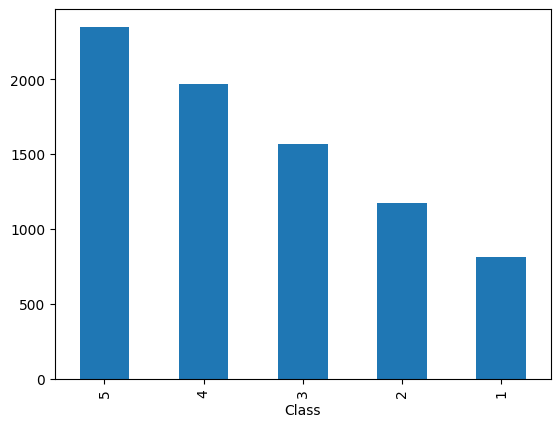

In [10]:
# distribución de variable objetivo
df_original['Class'].value_counts().plot(kind='bar')

Todos los valores de la columna 'Class' son válidos.

In [11]:
df_original.duplicated().sum()

71

Hay 71 registro duplicados, estos se deben eliminar del dataset.

In [12]:
duplicated_rows = df_original[df_original.duplicated()]
duplicated_rows


,Review,Class
518,"La ubicación es muy buena, al igual que la vista, la playa contrario a lo que esperaba resultó que estaba bastante limpia.\nSe percibe el sabor y la frescura en los insumos de los alimentos , lo cual es parte de la experiencia que ofrece...el lugar ya que tienen sus propias granjas productoras. La carta es limitada ( lo cual en mi caso prefiero, ya que se nota el esmero en cada uno de los platos que preparan), los precios están por arriba del promedio de otros restaurantes cercanos pero no llegan a ser exagerados, desconozco si eso se debió a que solo se tenía un salón disponible, ya que en la fecha que lo visité, el resto del restaurante se encontraba en remodelación (es la único razón por lo cual no otorgo la evaluación más alta), mi sugerencia sería que siguieran manteniendo los precios ya que los hace muy competitivos … sin duda regresaría, es un lugar que debes visitar en Veracruz sobre todo si eres fanático del buen comer…Más",4
1112,"El lugar es una maravilla que merece ser visitado. El servicio de cobro es pésimo y no es por el dinero porque mucha gente entra gratis, se hacen filas de más de 1 hora para pasar a pleno sol y mucha gente se mete disque al baño y no hace fila. Esta muy desorganizado.",2
1605,"Cierran a las 3 pm, cobraron $85 adultos y niños (por lo menos los de 2 años) y adulto mayor gratis. A la entrada hay guías. Se juntan grupos de mínimo 10 personas y te cobran $70 por persona o $700 a quien se los pague. Excelente explicación y atención de parte de ellos. Poca claridad de información en redes, y el número telefónico no sirve. Llegamos fácilmente con waze. Lleven buen bloqueador, sombrero y de preferencia tenis.",3
1843,"Acudimos un sábado 2 de julio a las 11:15 de la mañana. Estuvimos esperando más de media hora nosotros dos y otro grupo de cuatro personas fuera, porque la camarera estaba dentro. Nos vio como estábamos esperando y no fue capaz de salir a atendernos...o dar alguna explicación si el bar estaba abierto o cerrado.\n\nNos tuvimos que marcharMás",1
1851,"El lugar es una maravilla que merece ser visitado. El servicio de cobro es pésimo y no es por el dinero porque mucha gente entra gratis, se hacen filas de más de 1 hora para pasar a pleno sol y mucha gente se mete disque al baño y no hace fila. Esta muy desorganizado.",2
...,...,...
7520,"Un lugar muy limpio ordenado hermoso con áreas amplias que vale la pena disfrutar en familia un momento, primera vez que lo visito pero vale la pena acudir.",3
7601,"El lugar es una maravilla que merece ser visitado. El servicio de cobro es pésimo y no es por el dinero porque mucha gente entra gratis, se hacen filas de más de 1 hora para pasar a pleno sol y mucha gente se mete disque al baño y no hace fila. Esta muy desorganizado.",2
7756,Deben de actualizar los horarios en las diferentes páginas ya que como yo o cualquiera de los visitantes que vamos podemos llegar y encontrar cerrado y luego la página para buscar información no funciona.,3
7794,"Wow Había escuchado muchas recomendaciones de este lugar, pero nunca había ido, hace unos fui y me precio muy interesante toda las historias que hay en este museo.",5


# Procesamiento y Preparación

In [13]:
# eliminar las filas duplicadas
df_prep = df_original.drop_duplicates()

In [14]:
df_prep.shape

(7804, 2)

In [15]:
# TODO: balancear las clases (variable objetivo)

In [16]:
# elimnar filas con texto en otros idiomas
def detect_language(text):
    try:
        language = detect(text)
        return language == 'es'  # Check if language is Spanish
    except:
        return False

In [17]:
df_prep = df_prep[df_prep['Review'].apply(detect_language)]

In [18]:
df_prep.shape

(7797, 2)

In [19]:
# TODO: guardar datos despues de transformaciones de limpieza
# df_prep.to_csv('data/tipo1_entrenamiento_estudiantes_prep.csv', index=False)

## Divisón en entrenamiento y prueba 

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df_prep["Review"], df_prep["Class"], test_size = 0.3, stratify = df_prep["Class"], random_state = SEED)

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5457,), (2340,), (5457,), (2340,))

## Tokenización / Vectorización

"Feature engineering"

* Bag of Words / Count Tokenizer
* Tf-IDF

In [22]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/mci/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mci/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
stop_words = set(stopwords.words('spanish'))

In [24]:
def tokenize_text(text):
    # convertir a minúsculas
    text = text.lower()
    
    # eliminar caracteres numericos
    text = re.sub(r'\d+', '', text) 

    # eliminar puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # eliminar caracters especiales
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons TODO: not all emojis included here
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               "]+", flags=re.UNICODE)
    
    text = emoji_pattern.sub(r'', text)

    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')  
     
    tokens = word_tokenize(text)

    # eliminar los stems de las palabras
    stemmer = SnowballStemmer('spanish')
    tokens = [stemmer.stem(t) for t in tokens]
    return tokens

In [25]:
bow_vectorizer = CountVectorizer(stop_words=list(stop_words), tokenizer=tokenize_text)
tfidf_vectorizer = TfidfVectorizer( stop_words=list(stop_words), tokenizer=tokenize_text)

In [26]:
X_train_bow = bow_vectorizer.fit_transform(X_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['algun', 'com', 'contr', 'cuand', 'desd', 'dond', 'durant', 'eram', 'estab', 'estais', 'estam', 'estan', 'estand', 'estareis', 'estari', 'estariais', 'esteis', 'estem', 'esten', 'estes', 'estuv', 'estuvier', 'estuvies', 'fuer', 'fues', 'fuim', 'fuist', 'hab', 'habeis', 'habi', 'habiais', 'habr', 'habreis', 'habri', 'habriais', 'hast', 'hayais', 'hem', 'hub', 'hubier', 'hubies', 'mas', 'mia', 'mias', 'mio', 'mios', 'much', 'nad', 'nosotr', 'nuestr', 'par', 'per', 'poc', 'porqu', 'qui', 'seais', 'seam', 'sent', 'ser', 'sereis', 'seri', 'seriais', 'si', 'sient', 'sint', 'sobr', 'som', 'suy', 'tambi', 'ta

In [27]:
len(bow_vectorizer.vocabulary_)

12539

In [28]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

In [29]:
len(tfidf_vectorizer.vocabulary_)

12539

In [30]:
df_bow_sklearn = pd.DataFrame(X_train_bow.toarray(),columns=bow_vectorizer.get_feature_names_out())
df_bow_sklearn

,...,......,8,aa,aaaaa,ab,abad,abaj,abajol,abajom,...,zonasi,zonassi,zoo,zoolog,zorr,zotan,zuegly,zul,zum,zumb
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5452,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5453,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5454,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5455,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
df_tfid_sklearn = pd.DataFrame(X_train_tfidf.toarray(),columns=tfidf_vectorizer.get_feature_names_out())
df_tfid_sklearn

,...,......,8,aa,aaaaa,ab,abad,abaj,abajol,abajom,...,zonasi,zonassi,zoo,zoolog,zorr,zotan,zuegly,zul,zum,zumb
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.284381,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.082532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5452,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5453,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5454,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5455,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Eliminación de palabras con baja frecuencia

In [32]:
# Obtener el vocabulario
vocabulario = bow_vectorizer.vocabulary_

# Obtener la suma de las frecuencias de cada palabra en todo el conjunto de datos
frecuencia_total = X_train_bow.sum(axis=0)
# Crear un diccionario que mapea cada palabra a su frecuencia total
frecuencias = {palabra: frecuencia_total[0, indice] for palabra, indice in vocabulario.items()}

# Convertir el diccionario de frecuencias en un DataFrame
df_frecuencias = pd.DataFrame(list(frecuencias.items()), columns=['Palabra', 'Frecuencia'])

# Ordenar el DataFrame por frecuencia de forma descendente
df_frecuencias = df_frecuencias.sort_values(by='Frecuencia', ascending=False)
# Imprimir las frecuencias de cada palabra
df_frecuencias

,Palabra,Frecuencia
39,par,4456
5,com,3618
110,hotel,2764
179,per,2760
12,buen,2492
...,...,...
7198,preguntarnegoci,1
7194,technooogy,1
7193,advanc,1
7191,guym,1


In [33]:
df_palabras_altafrec = df_frecuencias[df_frecuencias['Frecuencia'] > 50]
df_palabras_altafrec.describe()

,Frecuencia
count,725.000000
mean,228.954483
std,358.292497
min,51.000000
25%,73.000000
50%,117.000000
75%,256.000000
max,4456.000000


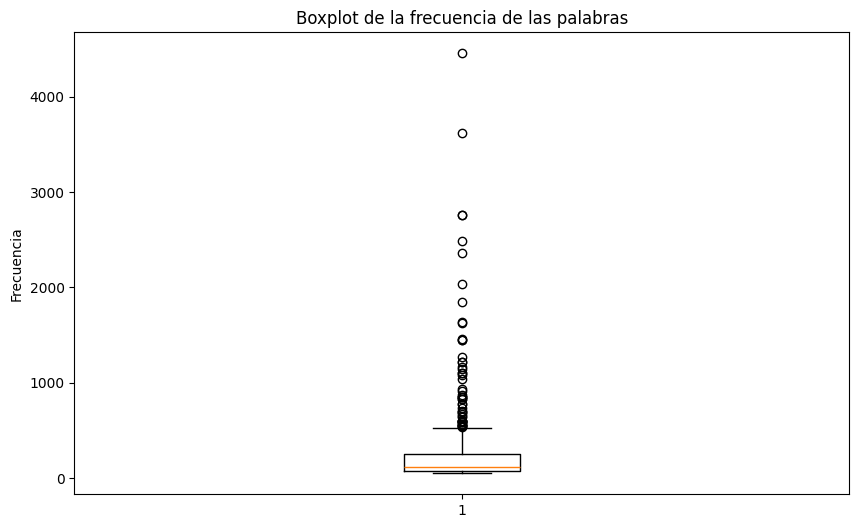

In [34]:
# Box plot
plt.figure(figsize=(10, 6))
plt.boxplot(df_palabras_altafrec['Frecuencia'])
plt.title('Boxplot de la frecuencia de las palabras')
plt.ylabel('Frecuencia')
plt.show()

In [35]:
# Obtener las palabras de alta frecuencia como una lista
palabras_altafrecuencia = df_palabras_altafrec['Palabra'].tolist()

# Filtrar las columnas que coinciden con las palabras de alta frecuencia
df_bow_sklearn_filtrado = df_bow_sklearn[palabras_altafrecuencia]

len(df_bow_sklearn_filtrado.columns)

725

In [36]:
# Convertir el DataFrame de nuevo a un array de NumPy
X_train_bow_filtered = df_bow_sklearn_filtrado.to_numpy()
X_train_bow_filtered.shape

(5457, 725)

# Entrenamiento y evaluación de modelos

## [nombre algoritmo]

Desarrollado por:

[descripción]

### Conclusiones

## Naive Bayes

Desarrollado por: Maria Castro Iregui

[descripción]

In [37]:
from datetime import datetime
current_time = datetime.now().strftime("%H:%M:%S")
print("Current time:", current_time)


Current time: 10:04:16


### Entrenamiento sin filtro de palabras

In [38]:
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_bow, y_train)


MultinomialNB()

In [83]:
df_feature_importance = pd.DataFrame(naive_bayes.feature_log_prob_.transpose(), index=bow_vectorizer.get_feature_names_out(), columns=naive_bayes.classes_)
df_feature_importance = df_feature_importance.apply(lambda x: np.exp(x), axis=0)

In [98]:
df_feature_importance[1].sort_values(ascending=False).head(20)

par        0.012340
hotel      0.011244
com        0.010785
habit      0.009153
per        0.007394
tod        0.006986
mal        0.005915
estab      0.005788
mas        0.005686
si         0.005201
habi       0.004742
servici    0.004207
lleg       0.004054
nuestr     0.003824
hac        0.003824
tien       0.003773
noch       0.003646
sol        0.003646
lug        0.003493
much       0.003416
Name: 1, dtype: float64

In [99]:
df_feature_importance[2].sort_values(ascending=False).head(20)

par        0.015395
hotel      0.012210
com        0.011982
per        0.011584
habit      0.010769
tod        0.007072
mas        0.006996
buen       0.006370
estab      0.006200
much       0.005801
mal        0.005631
si         0.005631
servici    0.005005
tien       0.004816
sol        0.004512
lug        0.004304
nuestr     0.004038
hac        0.004000
mejor      0.003981
lleg       0.003962
Name: 2, dtype: float64

In [100]:
df_feature_importance[3].sort_values(ascending=False).head(20)

par        0.016580
per        0.014038
com        0.013264
hotel      0.010975
buen       0.009544
habit      0.008029
mas        0.007827
tod        0.007322
si         0.007305
lug        0.005555
much       0.005538
tien       0.005521
estab      0.005033
bien       0.004696
poc        0.004595
servici    0.004578
mejor      0.004578
sol        0.004208
restaur    0.004174
pued       0.004090
Name: 3, dtype: float64

In [101]:
df_feature_importance[4].sort_values(ascending=False).head(20)

par        0.017793
buen       0.013191
com        0.012985
per        0.010012
hotel      0.009300
tod        0.008272
lug        0.007355
tien       0.006374
mas        0.006216
si         0.005979
habit      0.005915
bien       0.005805
pued       0.005662
much       0.005378
visit      0.004998
servici    0.004745
restaur    0.004508
vist       0.004175
ciud       0.004175
poc        0.004033
Name: 4, dtype: float64

In [102]:
df_feature_importance[5].sort_values(ascending=False).head(20)

par         0.016118
com         0.014651
tod         0.011703
buen        0.009610
excelent    0.008082
lug         0.007287
servici     0.006997
hotel       0.006783
mas         0.006203
per         0.006065
visit       0.005760
restaur     0.005546
much        0.005439
pued        0.005378
si          0.005011
tien        0.004889
mejor       0.004874
bien        0.004675
nuestr      0.004568
ciud        0.004278
Name: 5, dtype: float64

In [41]:
y_train_naive_predict = naive_bayes.predict(X_train_bow)
y_test_naive_predict = naive_bayes.predict(bow_vectorizer.transform(X_test))

In [42]:
print('Clases', len(naive_bayes.classes_))
print('Etiquetas:', naive_bayes.classes_)
print('Features:', len(naive_bayes.feature_log_prob_[0]))
print('Features relevantes', np.count_nonzero(naive_bayes.feature_log_prob_))
print('Prior probabilities:', naive_bayes.class_log_prior_)
print('Feature log probabilities:', naive_bayes.feature_log_prob_)

Clases 5
Etiquetas: [1 2 3 4 5]
Features: 12539
Features relevantes 62695
Prior probabilities: [-2.29291966 -1.90515413 -1.6153192  -1.37990106 -1.20464495]
Feature log probabilities: [[ -6.1226458  -10.57699309 -10.57699309 ...  -9.88384591  -9.19069873
  -10.57699309]
 [ -6.20039543 -10.87322426 -10.87322426 ... -10.18007708  -8.79378272
   -9.77461197]
 [ -6.31008661 -10.29907066 -10.99221784 ... -10.99221784  -9.38277993
  -10.99221784]
 [ -6.86481615 -11.05447089 -11.05447089 ... -11.05447089  -9.44503298
  -11.05447089]
 [ -7.26047677  -9.99050587 -10.39597098 ... -11.08911816  -9.99050587
  -10.39597098]]


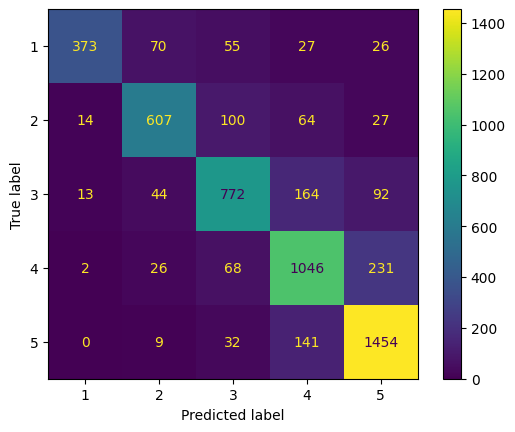

In [43]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_naive_predict)

In [45]:
print("accuracy:", naive_bayes.score(bow_vectorizer.transform(X_train), y_train))
print("precision:", precision_score(y_train, y_train_naive_predict, average='macro'))
print("recall:", recall_score(y_train, y_train_naive_predict, average='macro'))
print("f1:", f1_score(y_train, y_train_naive_predict, average='macro'))

accuracy: 0.7791827011178303
precision: 0.8004783350930549
recall: 0.7573194269001677
f1: 0.7740511242426076


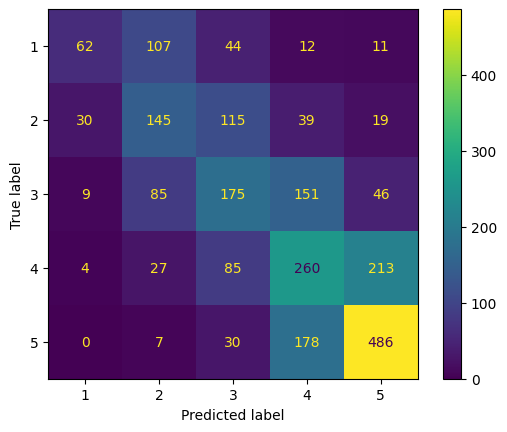

In [46]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_naive_predict)

In [47]:
print("accuracy:", naive_bayes.score(tfidf_vectorizer.transform(X_test), y_test))
print("precision:", precision_score(y_test, y_test_naive_predict, average='macro'))
print("recall:", recall_score(y_test, y_test_naive_predict, average='macro'))
print("f1:", f1_score(y_test, y_test_naive_predict, average='macro'))

accuracy: 0.4653846153846154
precision: 0.4808827110640842
recall: 0.43792729004194014
f1: 0.4462265595339633


### Entrenamiento con filtro de palabras

In [48]:
naive_bayes_filtered = MultinomialNB()
naive_bayes_filtered.fit(X_train_bow_filtered, y_train)

MultinomialNB()

In [106]:
df_feature_importance_filtered= pd.DataFrame(naive_bayes_filtered.feature_log_prob_.transpose(), index=df_palabras_altafrec['Palabra'], columns=naive_bayes_filtered.classes_)
df_feature_importance_filtered = df_feature_importance_filtered.apply(lambda x: np.exp(x), axis=0)

In [107]:
df_feature_importance_filtered[1].sort_values(ascending=False).head(20)

Palabra
par        0.023563
hotel      0.021469
com        0.020593
habit      0.017477
per        0.014118
tod        0.013339
mal        0.011294
estab      0.011051
mas        0.010856
si         0.009931
habi       0.009055
servici    0.008033
lleg       0.007741
nuestr     0.007302
hac        0.007302
tien       0.007205
noch       0.006962
sol        0.006962
lug        0.006670
much       0.006524
Name: 1, dtype: float64

In [108]:
df_feature_importance_filtered[2].sort_values(ascending=False).head(20)

Palabra
par        0.025754
hotel      0.020426
com        0.020045
per        0.019379
habit      0.018015
tod        0.011830
mas        0.011704
buen       0.010657
estab      0.010371
much       0.009705
mal        0.009420
si         0.009420
servici    0.008373
tien       0.008056
sol        0.007549
lug        0.007200
nuestr     0.006756
hac        0.006692
mejor      0.006661
lleg       0.006629
Name: 2, dtype: float64

In [109]:
df_feature_importance_filtered[3].sort_values(ascending=False).head(20)

Palabra
par        0.026648
per        0.022562
com        0.021318
hotel      0.017639
buen       0.015339
habit      0.012904
mas        0.012580
tod        0.011768
si         0.011741
lug        0.008928
much       0.008901
tien       0.008873
estab      0.008089
bien       0.007548
poc        0.007386
mejor      0.007359
servici    0.007359
sol        0.006763
restaur    0.006709
pued       0.006574
Name: 3, dtype: float64

In [110]:
df_feature_importance_filtered[4].sort_values(ascending=False).head(20)

Palabra
par        0.028099
buen       0.020831
com        0.020506
per        0.015810
hotel      0.014686
tod        0.013063
lug        0.011614
tien       0.010066
mas        0.009816
si         0.009441
habit      0.009341
bien       0.009167
pued       0.008942
much       0.008492
visit      0.007893
servici    0.007493
restaur    0.007118
ciud       0.006594
vist       0.006594
poc        0.006369
Name: 4, dtype: float64

In [111]:
df_feature_importance_filtered[5].sort_values(ascending=False).head(20)

Palabra
par         0.026020
com         0.023652
tod         0.018892
buen        0.015513
excelent    0.013047
lug         0.011764
servici     0.011296
hotel       0.010951
mas         0.010013
per         0.009791
visit       0.009298
restaur     0.008953
much        0.008780
pued        0.008681
si          0.008090
tien        0.007892
mejor       0.007868
bien        0.007547
nuestr      0.007374
ciud        0.006906
Name: 5, dtype: float64

In [54]:
#  la eliminacion frecuencias bajas en text

# X_test as df
X_test_bow = bow_vectorizer.transform(X_test)
df_X_test_bow = pd.DataFrame(X_test_bow.toarray(),columns=bow_vectorizer.get_feature_names_out())

df_X_test_bow_filtrado = df_X_test_bow[palabras_altafrecuencia]
X_test_bow_filtrado = df_X_test_bow_filtrado.to_numpy()

# Filtrar las columnas que coinciden con las palabras de alta frecuencia

y_test_naive_predict = naive_bayes_filtered.predict(X_test_bow_filtrado)

In [55]:
print('Clases', len(naive_bayes_filtered.classes_))
print('Etiquetas:', naive_bayes_filtered.classes_)
print('Features:', len(naive_bayes_filtered.feature_log_prob_[0]))
print('Features relevantes', np.count_nonzero(naive_bayes_filtered.feature_log_prob_))
print('Prior probabilities:', naive_bayes_filtered.class_log_prior_)
print('Feature log probabilities:', naive_bayes_filtered.feature_log_prob_)

Clases 5
Etiquetas: [1 2 3 4 5]
Features: 725
Features relevantes 3625
Prior probabilities: [-2.29291966 -1.90515413 -1.6153192  -1.37990106 -1.20464495]
Feature log probabilities: [[-3.74809326 -3.88280599 -3.84113329 ... -8.32074026 -8.1384187
  -8.54388381]
 [-3.6591627  -3.90977364 -3.89096431 ... -9.26005075 -8.05607794
  -7.79371368]
 [-3.6250581  -3.84820166 -4.03765518 ... -7.80964954 -8.0327931
  -8.0327931 ]
 [-3.57202099 -3.8870362  -4.22083236 ... -7.76434596 -8.19966403
  -7.8895091 ]
 [-3.64889637 -3.74430134 -4.51436785 ... -7.83760369 -7.77697907
  -8.12528576]]


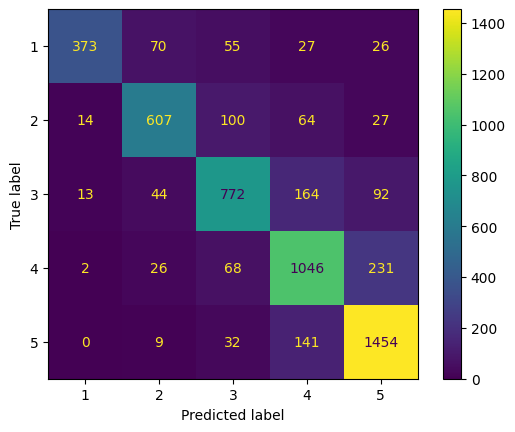

In [56]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_naive_predict)

In [57]:
print("accuracy:", naive_bayes_filtered.score(X_train_bow_filtered, y_train))
print("precision:", precision_score(y_train, y_train_naive_predict, average='macro'))
print("recall:", recall_score(y_train, y_train_naive_predict, average='macro'))
print("f1:", f1_score(y_train, y_train_naive_predict, average='macro'))

accuracy: 0.5719259666483416
precision: 0.8004783350930549
recall: 0.7573194269001677
f1: 0.7740511242426076


In [58]:
print("accuracy:", naive_bayes_filtered.score(X_test_bow_filtrado, y_test))
print("precision:", precision_score(y_test, y_test_naive_predict, average='macro'))
print("recall:", recall_score(y_test, y_test_naive_predict, average='macro'))
print("f1:", f1_score(y_test, y_test_naive_predict, average='macro'))

accuracy: 0.4735042735042735
precision: 0.4421463570909315
recall: 0.44632449700728094
f1: 0.4422274304064646


### Conclusiones

## [nombre algoritmo]

Desarrollado por:

[descripción]

### Conclusiones

## Selección de final